# NLP-App-Sentiment-Analysis
Author: Jennifer Ha
***

## Overview
With their recent successful real estate investment in New York, our client Stellar Property Group seeks to expand their listings in California, which happens to be the other state with the most Fortune 500 company headquarters besides New York. Our client believes the trends and contributing factors that they saw in New York, especially the continued job growth will also positively impact the home values in California. The team is looking for recommendations on top 5 zipcodes to invest in California, and this analysis will also provide them with short-term vs. long-term investment decisions.

## Business Understanding
The goal of this analysis is to identify the top 5 zipcodes for our client to invest in California. The team is not quite familiar with the West Coast real estate market, and therefore, has asked to take risk factor into consideration. The results from this analysis will provide them with the forecast of next 10 year mean house values in the top 5 zipcodes as well as expected ROI in 1 year, 3 years, 5 years, and 10 years. 

## Data
The dataset for this analysis comes from [Zillow Research](https://www.zillow.com/research/data/), which contains the median home sales prices in 14,723 individual zipcodes from April 1996 through April 2018. Each row represents a unique zip code indexed with RegioinID, and contains location info and median housing sales prices for each month.

In [1]:
# Import all libraries & packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
import string
from PIL import Image
import urllib.request

# Import standard packages for Natural Language Processing
import nltk
from nltk import FreqDist, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

# Importa SciKit Learn packages for modeling and model evaluation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, roc_curve

# Import LIME packages for feature interpretation
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer



In [2]:
# Set random seed
np.random.seed(27)

# Set no limit to column width to view full review text
pd.options.display.max_colwidth = None

## Importing Data

In [3]:
all_files = [
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/caviar-order-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/deliveroo-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/doordash-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/foodpanda-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/grubhub-local-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/postmates-fast-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/seamless-local-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/toast-takeout-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/uber-eats-food-delivery.csv',
    'https://raw.githubusercontent.com/jennifernha/NLP-App-Reviews-Sentiment-Analysis/master/data/zomato-food-delivery-dining.csv'
]
    

In [4]:
# Create a list of all loaded review text dataframes
df_list = []

for file in all_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)

In [5]:
# Concatenate all tables into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)
df

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
0,9/17/20 17:12,Good64774,Mixed feelings,"Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,False,caviar-order-food-delivery,931355786,NaN
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful","They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating.\n\nThe last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. \n\nI was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,False,caviar-order-food-delivery,931355786,NaN
2,11/4/20 0:18,Mighty Power,Deliveries take too long,"Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an 

## Data Preparation

In [6]:
# Get summary of the DataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67033 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67033 non-null  object
 1   userName           67033 non-null  object
 2   title              67033 non-null  object
 3   review             67033 non-null  object
 4   rating             67033 non-null  int64 
 5   isEdited           67033 non-null  bool  
 6   app_name           67033 non-null  object
 7   app_id             67033 non-null  int64 
 8   developerResponse  17242 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.2+ MB


In [7]:
# Check value counts for isEdited column
df['isEdited'].value_counts()

False    66093
True       940
Name: isEdited, dtype: int64

In [8]:
# Check value counts for developerResponse column
(df['developerResponse'].isna()).value_counts()

True     49791
False    17242
Name: developerResponse, dtype: int64

In [9]:
# Preview sample developer responses
df[df['developerResponse'].isna()==False]

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
3,12/24/18 2:52,anogawa,Horrendous customer service,"I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. \n\nOur expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their twitter account offers me $30, saying the restaurant is closed, which is why a re-delivery wasn’t available. \n\nThe correct response would have been to offer expedited delivery form another restaurant. At this point, I am not going to use this app again and will not recommend this app to my friends. Note to the developers: there are other food delivery apps out there, you are the new guy and you need to do more to stand out besides offer different restaurant selections.",1,False,caviar-order-food-delivery,931355786,"{'id': 6547062, 'body': ""Thanks for the feedback and I'm so sorry to hear about the issue you've experienced. We strive to provide the best experience with our support as possible, and clearly, we fell short here. Could you send us more details of your experience at trycaviar.com/contact with ATTN: Angie in the subject line? I'd be happy to help find a proper resolution."", 'modified': '2018-12-25T23:56:02Z'}"
5,6/4/19 0:34,LJS57,Bad Service for the Outrageous Delivery & Service Fees,"UPDATE: I contacted customer service as directed below. The short answer is, they aren’t willing to refund orders, it’s against their policy. Even if it shows up over an hour late (nearly 2 hours after the order was placed) and is cold and soggy- I’ve already gotten more than one credit for poor service. What I want is my money back. I informed them I’d be deleting the app, and got a canned response saying we hope this experience doesn’t reflect badly on them. I am deleting the app and will be ordering from DoorDash moving forward. DoorDash is now picking up many of the restaurants that were once specific to Caviar, they’re timely, and their fees are lower. I’m sorry Caviar, I tried. \n. . . . . . \nIf the food ever got to me in a timely manner, or even lukewarm, I wouldn’t be complaining. That said, nearly every time I’ve ever use this service, the delivery time increased from the posted 45-55 minutes, to 1.5-2 hours. That’s ridiculous. I wonder how they treat their restaurants as well because more than once I’ve received strange inaccurate orders- for example, a salad will show up bare (just a container of lettuce, minus any of the listed ingredients from the site), or most frequently, anything I add on as “extra” to a dish I get charged for, but the “extra” isn’t included. I’ve requested refunds, with no response. It’s a shame bc they work with some good places.",1,True,caviar-order-food-delivery,931355786,"{'id': 8970235, 'body': ""Thanks for the feedback and I'm so sorry to hear about the issue you've experienced. We strive to provide the best experience with our service and support as possible, and clearly we fell short here. Could you send us more details of your experience at trycaviar.com/contact with ATTN: Aicea in the subject line? I'd be happy to help find a proper resolution."", 'modified': '2019-06-04T00:34:55Z'}"
11,9/16/18 0:30,ndavidso

### Removing Duplicates

In [10]:
#Check for duplicates
df.title.duplicated().sum()

19571

In [11]:
# Check for duplicated rows
df[df.duplicated(keep=False)].sort_values('title')

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
1674,9/6/18 23:56,IFS123,Horrible horrible service in downtown Boston,You order something and it says it will\ntake an hour...then an 1.15....then 1.5....then 2.5 hours. \n\nThis is the third time this has happened to me. Never ordering from caviar again.,1,False,caviar-order-food-delivery,931355786,NaN
1675,9/6/18 23:56,IFS123,Horrible horrible service in downtown Boston,You order something and it says it will\ntake an hour...then an 1.15....then 1.5....then 2.5 hours. \n\nThis is the third time this has happened to me. Never ordering from caviar again.,1,False,caviar-order-food-delivery,931355786,NaN
21354,2017-12-18 22:38:24,Alaskagrown57,ORDERED MULTIPLE TIMES,I have ordered from different restaurants but always come back to this restaurant. The food is great and the delivery guy is always friendly. My food usually comes before the designated time and what I ordered has been right each time!!!! Maybe once it was a little late but that is because I live in moble home park and sometimes it is hard to find!!!!,5,False,grubhub-local-food-delivery,302920553,NaN
22086,2017-12-18 22:38:24,Alaskagrown57,ORDERED MULTIPLE TIMES,I have ordered from different restaurants but always come back to this restaurant. The food is great and the delivery guy is always friendly. My food usually comes before the designated time and what I ordered has been right each time!!!! Maybe once it was a little late but that is because I live in moble home park and sometimes it is hard to find!!!!,5,False,grubhub-local-food-delivery,302920553,NaN
21514,2017-12-10 21:23:44,Catzarn,Pretty Good!,"They work with a lot of restaurants and whenever I have an issue, the support staff always helps me resolve it.\n\nThere is a slight issue with the drivers having a small problem finding my apartment, they always go into my alley behind my building or to an address two blocks over, but that is more of their GPS/maps problem than theirs.",5,False,grubhub-local-food-delivery,302920553,NaN
22336,2017-12-10 21:23:44,Catzarn,Pretty Good!,"They work with a lot of restaurants and whenever I have an issue, the support staff always helps me resolve it.\n\nThere is a slight issue with the drivers having a small problem finding my apartment, they always go into my alley behind my building or to an address two blocks over, but that is more of their GPS/maps problem than theirs.",5,False,grubhub-local-food-delivery,302920553,NaN
21357,2017-12-15 02:56:55,Christian-In-Training,Questionable Drivers,"Placed an order THREE TIMES with them and the drivers decided not to come. Gave them instructions every single time about my apartment number. Instead of calling me about getting into my gated community with the passcode, they decided to just skip it. I called Grubhub and every time (almost 20 minute wait time each time) I told them to inform the driver to call me so I can let them in. Never happened. The customer service agents were not helpful. Even their supervisor Diana was just a jerk. 3 hours later I ended up having to go get it myself. Sometimes the “convenience” isn’t worth it.",1,False,grubhub-local-food-delivery,302920553,NaN
22174,2017-12-15 02:56:55,Christian-In-Training,Questionable Drivers,"Placed an order THREE TIMES with them and the drivers decided not to come. Gave them instructions every single time about my apartment number. Instead of calling me about getting into my gated community with the passcode, they decided to just skip it. I called Grubhub and every time (almost 20 minute wait time each time) I told them to inform the driver to call me so I can let them in. Never happened. The customer service agents were not helpful. Even their supervisor Diana was just a jerk. 3 hours later I ended up having to go get it myself. Sometimes the “convenience” isn’t worth it.",1,False,grubhub-local-food-delivery,302920553,NaN


In [12]:
#Remove duplicated rows
df = df.drop_duplicates()

In [13]:

# Check for multiple reviews for same app from same user
df[df.duplicated(['userName', 'app_name'], keep=False)]

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse
38803,2018-09-11 23:16:10,Marcus350,I can’t use coupon,I got 10$ off on order made by app but I can use it because when I’m trying to checkout I’m getting message that order can’t be processed because for pick up I have to add phone number and @ address. And the best part of it that my phone and @ is in the system. When I removed coupon order went threw without any issue.,1,False,seamless-local-food-delivery,381840917,"{'id': 5675538, 'body': ""Oh No Marcus350! We're so sorry to hear that you're having the issues when using promotional codes. Please give us a call 800-256-1020 before check out and we're happy to help troubleshoot those promos with you! You can also check https://www.seamless.com/promoterms for full details."", 'modified': '2018-10-26T15:59:46Z'}"
40332,2018-09-11 23:43:11,Marcus350,Impossible to order by app,It is impossible to order by app it showing error message,1,False,seamless-local-food-delivery,381840917,"{'id': 5109101, 'body': 'Hi Marcus350! We are so sorry that you are experiencing issues with using the app. We would love the opportunity to resolve any issues that you may be experiencing. Please contact our Customer Care Team by giving us a call at (877) 256-1020. Thank you for choosing Seamless!', 'modified': '2018-09-19T01:31:36Z'}"
61065,2019-07-12 19:49:02,mohammedalhashimi,if you want your food late and cold ..... use this app,I have been using this app over a year and always my orders are late.,1,False,zomato-food-delivery-dining,434613896,"{'id': 9686084, 'body': 'Hi there, apologies for the inconvenience caused. Kindly drop us a mail (order@zomato.com) regarding this so that we can look in to what went wrong. Thanks.', 'modified': '2019-07-16T11:25:55Z'}"
61066,2019-07-12 19:49:02,mohammedalhashimi,if you want your food late and cold ..... use this app,I have been using this app over a year and always my orders are late.,1,False,zomato-food-delivery-dining,434613896,"{'id': 9686086, 'body': 'Hi there, apologies for the inconvenience caused. Kindly drop us a mail (order@zomato.com) regarding this so that we can look in to what went wrong. Thanks.', 'modified': '2019-07-16T11:25:58Z'}"


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67029 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67029 non-null  object
 1   userName           67029 non-null  object
 2   title              67029 non-null  object
 3   review             67029 non-null  object
 4   rating             67029 non-null  int64 
 5   isEdited           67029 non-null  bool  
 6   app_name           67029 non-null  object
 7   app_id             67029 non-null  int64 
 8   developerResponse  17242 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.7+ MB


While the review by Marcus 350 is legit, remove review by mohammedalhashimi 

In [15]:
# delete a single row by index value 0
df = df.drop(labels=61066, axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67028 entries, 0 to 67032
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               67028 non-null  object
 1   userName           67028 non-null  object
 2   title              67028 non-null  object
 3   review             67028 non-null  object
 4   rating             67028 non-null  int64 
 5   isEdited           67028 non-null  bool  
 6   app_name           67028 non-null  object
 7   app_id             67028 non-null  int64 
 8   developerResponse  17241 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 4.7+ MB


### Feature Engineering
we will combine them into one column, because both the title and review columns hold text that are relevant to our analysis. This will ensure that we are able to simultaneously examine information in the title and review columns.

In [16]:
# Combine title and review column to get full review text
df['combined_text'] = df['title'] + ". " + df['review']
df

,date,userName,title,review,rating,isEdited,app_name,app_id,developerResponse,combined_text
0,9/17/20 17:12,Good64774,Mixed feelings,"Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,False,caviar-order-food-delivery,931355786,NaN,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence."
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful","They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating.\n\nThe last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and

In [17]:
# Create a variable "corpus" containing all text
corpus = df['combined_text'].to_list()


In [18]:
corpus[3]

'Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible. \n\nOur expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their

In [19]:
# Replace all new-line characters with space
df['combined_text'] = df['combined_text'].replace(r'\n',' ', regex=True) 
# Create a variable "corpus" containing all text and verify
corpus = df['combined_text'].to_list()
corpus[3]

'Horrendous customer service. I would say the app experience is superior to other delivery apps, which is a shame because the customer service is terrible.   Our expected delivery time upon ordering was 8:24 pm, which eventually got pushed back to 8:49 pm. The app notified us of the delay, which is better than other food delivery apps in which I’ve experienced delays but wasn’t notified. However, when order finally arrived, my husband noticed the delivery guy gave us the wrong order. Turns out he had given our order to the wrong person. Driver says he’ll contact support, saying they’ll probably re-deliver. I contact customer support on my own, and the rep offers a refund...okay, but at this point it’s past 9 pm and we still haven’t had dinner. I reply back saying it’s not okay. Rep blames it on me, saying that I selected that the items were missing and I preferred a refund. Except there are no options for “my driver messed up, get me a new order asap”. Eventually he offers $10. Their t

## Exploratory Data Analysis (EDA)

### 1. Number of Reviews Distribution by App

In [20]:
# Check distribution of reviews for each app
df['app_name'].value_counts(normalize=True)

uber-eats-food-delivery         0.149191
seamless-local-food-delivery    0.149191
doordash-food-delivery          0.149191
postmates-fast-delivery         0.149191
grubhub-local-food-delivery     0.149147
zomato-food-delivery-dining     0.124754
caviar-order-food-delivery      0.060512
foodpanda-food-delivery         0.038894
deliveroo-food-delivery         0.018977
toast-takeout-delivery          0.010951
Name: app_name, dtype: float64

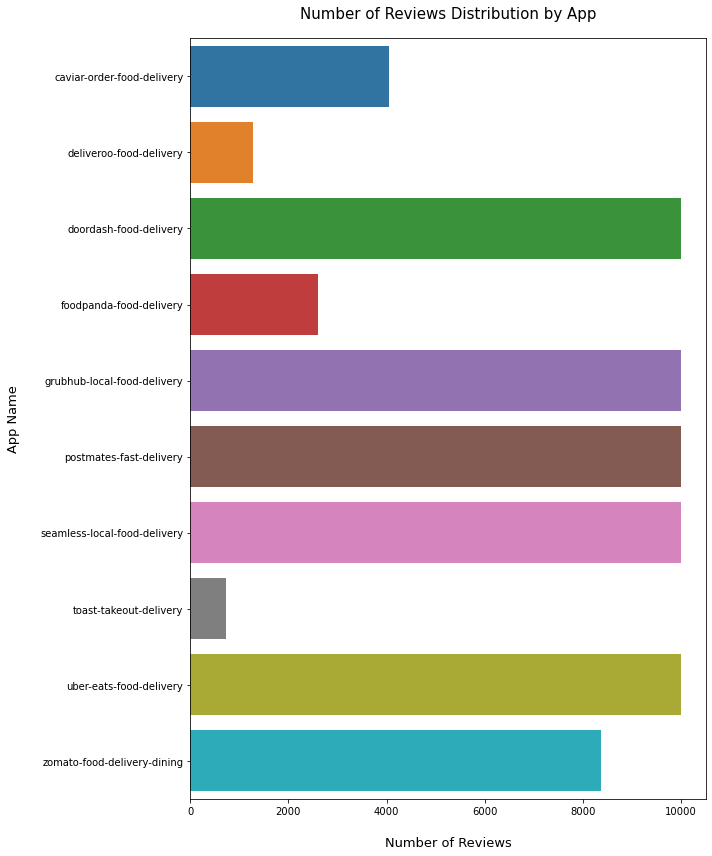

In [44]:
# Plot distribution of review count by app name
fig, ax = plt.subplots(figsize=(10,12))

sns.countplot(data=df, y='app_name', ax=ax)

plt.title('Number of Reviews Distribution by App', size = 15, pad = 20) 
plt.xlabel('Number of Reviews', size = 13, labelpad = 20)
plt.ylabel('App Name', size = 13, labelpad = 20)

plt.tight_layout()

### 2. Average Rating by App 


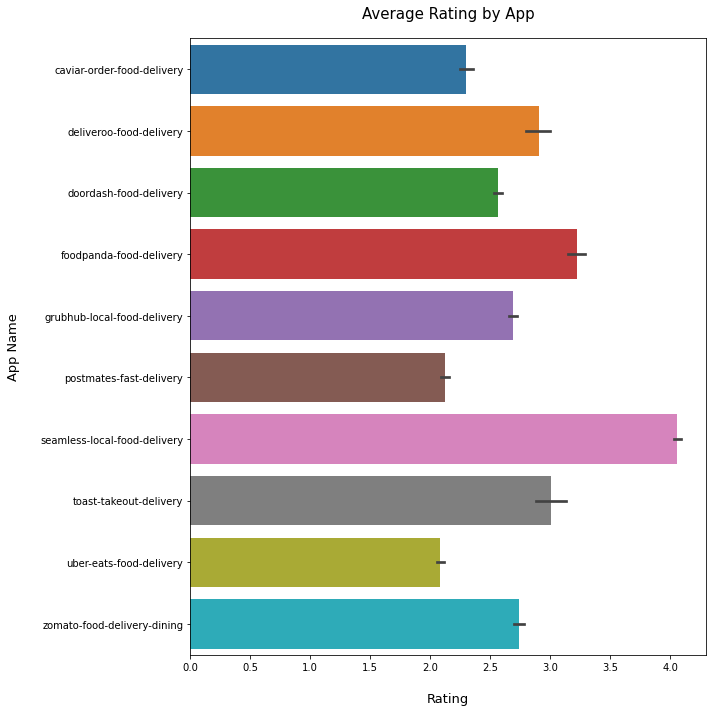

In [39]:
# Plot average rating by app 
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(data=df, x='rating', y='app_name')

plt.title('Average Rating by App', size = 15, pad = 20) 
plt.xlabel('Rating', size = 13, labelpad = 20)
plt.ylabel('App Name', size = 13, labelpad = 20)

plt.tight_layout()

### 3. Rating Distribution of All Apps 

In [41]:
# Check distribution of ratings across all apps
df['rating'].value_counts()

1    31175
5    21524
2     5202
4     5052
3     4075
Name: rating, dtype: int64

In [42]:
# Check distribution of ratings across all apps in percentages
df['rating'].value_counts(normalize=True)

1    0.465104
5    0.321120
2    0.077609
4    0.075371
3    0.060795
Name: rating, dtype: float64

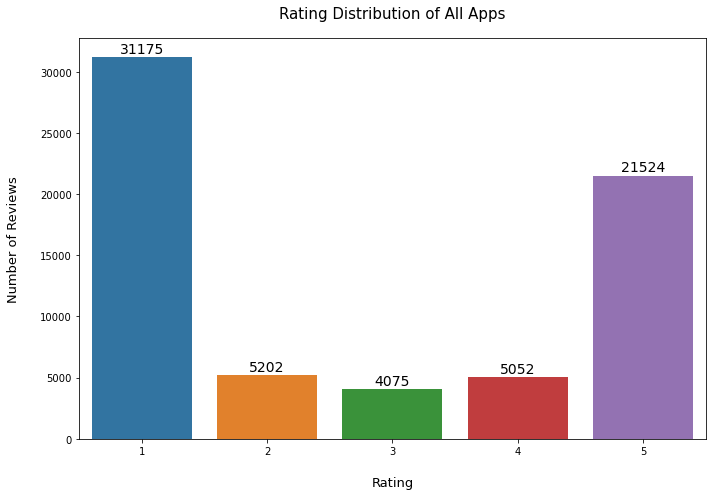

In [48]:
# Plot distribution of ratings across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='rating', data=df, ax=ax)

plt.title('Rating Distribution of All Apps', size = 15, pad = 20) 
plt.xlabel('Rating', size = 13, labelpad = 20)
plt.ylabel('Number of Reviews', size = 13, labelpad = 20)

# Show number of reviews for each bar
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')

fig.tight_layout();

### 4. Rating Distribution of Apps with Most Reviews (Top 5)

In [53]:
# Create dataframe with data for top five apps in terms of review count
distribution_df = df[df['app_name'].isin(['doordash-food-delivery', 'grubhub-local-food-delivery',
                                          'postmates-fast-delivery', 'seamless-local-food-delivery',
                                          'uber-eats-food-delivery'])]

# Calculate average mean rating across top five apps
distribution_df = distribution_df.groupby('app_name')['rating']\
                                 .value_counts(normalize=True).to_frame()

# Rename percentage column and app_name column
distribution_df.columns = ['percentage']

# Reset index, rename app column and display result
distribution_df.reset_index(inplace=True)
distribution_df.columns = ['App', 'rating', 'percentage']
distribution_df

,App,rating,percentage
0,doordash-food-delivery,1,0.470600
1,doordash-food-delivery,5,0.263600
2,doordash-food-delivery,2,0.100900
3,doordash-food-delivery,3,0.089800
4,doordash-food-delivery,4,0.075100
5,grubhub-local-food-delivery,1,0.452736
6,grubhub-local-food-delivery,5,0.302291
7,grubhub-local-food-delivery,2,0.093028
8,grubhub-local-food-delivery,4,0.080224
9,grubhub-local-food-delivery,3,0.071722


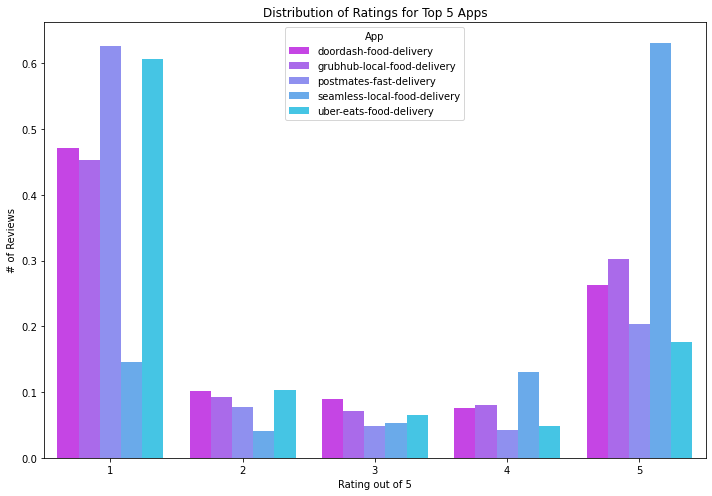

In [54]:
# Initialize figure
fig, ax = plt.subplots(figsize=(10,7))

# Create Barplot
sns.barplot(x='rating', y='percentage', hue='App', data=distribution_df, 
            ax=ax, palette='cool_r')

# Format barplot
ax.set_title('Distribution of Ratings for Top 5 Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Rating out of 5')
fig.tight_layout();

write observation from the above

## Target Engineering

### Multi-class Sentiments

In [55]:
# Make new multiclass sentiment column based on rating
# 4 and above are positive, 3 is neutral, 1-2 are negative
conditions = [df['rating'] >= 4,
              df['rating'] == 3,
              df['rating'] <= 2,]
values = [2, 1, 0]

df['multi_sent'] = np.select(conditions, values)

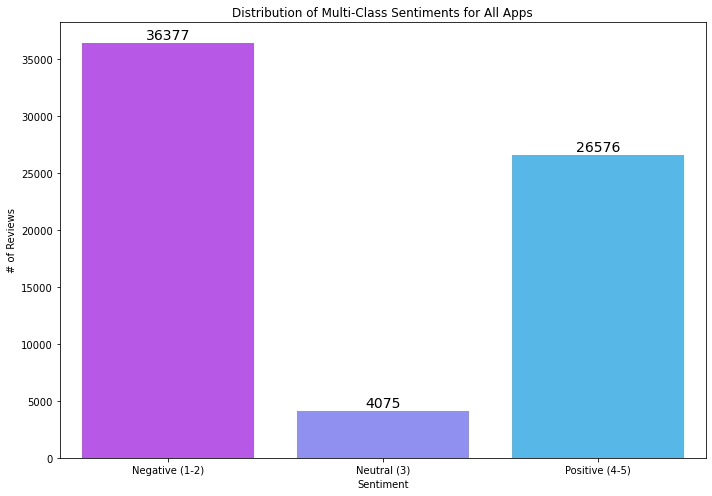

In [63]:
# Plot distribution of multiclass sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))

sns.countplot(x='multi_sent', data=df, ax=ax, palette='cool_r')

ax.set_title('Distribution of Multi-Class Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-2)','Neutral (3)', 'Positive (4-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

### Binary Sentiments

In [57]:
# Make new binary sentiment column based on ratings
# 3 and above are positive, below 3 is negative
conditions = [df['rating'] >= 3,
              df['rating'] < 3]

values = [1,0]

df['sent_bin_3up'] = np.select(conditions, values)

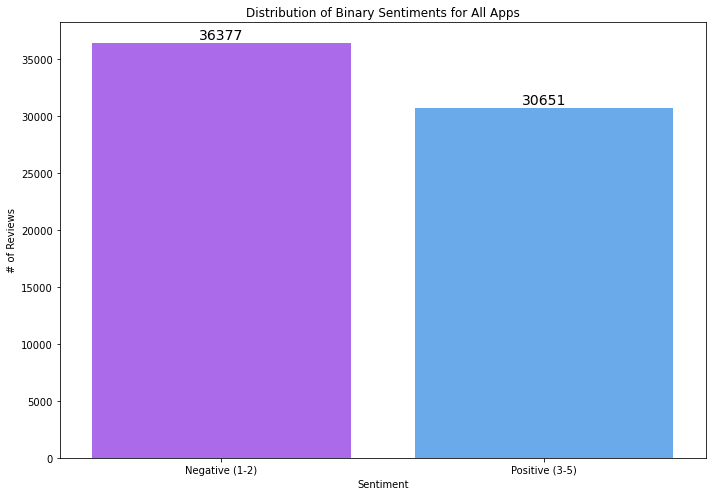

In [62]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_3up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-2)', 'Positive (3-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [59]:
## Make new binary sentiment column based on ratings 4 and up
conditions = [
    df['rating'] >= 4,
    df['rating'] < 4,
]

values = [1,0]

df['sent_bin_4up'] = np.select(conditions, values)

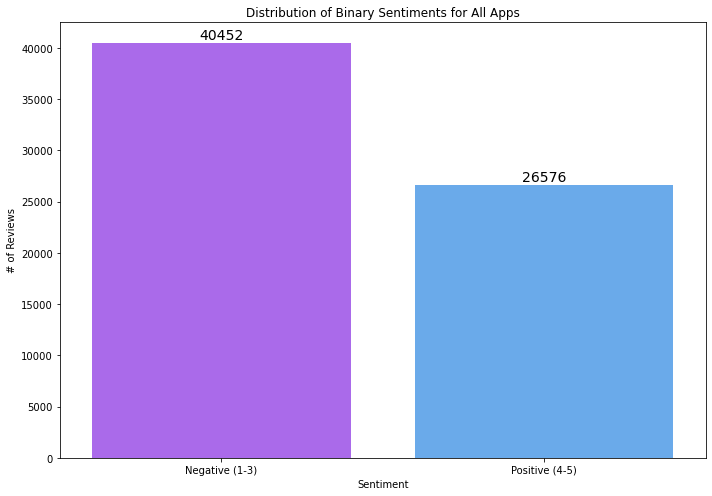

In [61]:
# Plot distribution of binary sentiments across all apps
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='sent_bin_4up', data=df, ax=ax, palette='cool_r')
ax.set_title('Distribution of Binary Sentiments for All Apps')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Sentiment')
ax.set_xticklabels(['Negative (1-3)', 'Positive (4-5)'])

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2.,
                                          p.get_height()),ha='center',
                va='center', fontsize=14, color='black', xytext=(0, 8),
                textcoords='offset points')
fig.tight_layout();

In [65]:
# Prepare final table with relevant columns
final_df = df[['date', 'userName', 'combined_text', 'rating', 'multi_sent', 
               'sent_bin_3up', 'sent_bin_4up']]
final_df

,date,userName,combined_text,rating,multi_sent,sent_bin_3up,sent_bin_4up
0,9/17/20 17:12,Good64774,"Mixed feelings. Caviar used to be a great app. Top quality restaurants, working app, good service. But they recently merged with DoorDash which I have found to be a notoriously worse app. Since the merger, the app seemed to change and your delivery drivers are now from “Dashers”. When you order now and have an issue and try to chat Caviar sometimes their servers are down or you can’t get a hold of them. Your left to call the restaurant who may tell you your food has been ready for a half hour but DoorDash/Caviar hasn’t picked it up and is unreachable right now. Typical DoorDash problems. Although the app needs work and the DoorDash merger is disappointing. When I finally have been able to reach the company and explain various issues. Caviar does issue refunds and credits. This is a positive that some apps like UberEats or Postmates rarely provide. Caviar’s credits/refunds are close to the high level of Seamless/Grubhub. Only reason Seamless/Grubhub are better in this area is refunds and credits can be issued automatically in the app with ease if you run into issues. Caviar, as mentioned above can be difficult to reach and requires more explanation. Ultimately if the Caviar app improves the accessibility of their customer service and they continue to provide credits, I would consider changing my review back to 5 stars. On the other hand, if I keep running into these app issues or if they stop providing credits and refunds for issues I would lower the rating. I’m on the fence.",5,2,1,1
1,5/20/20 18:18,weterpest,"Unreliable, Unhelpful. They have such a great selection of restaurants but service is SO unreliable! I have ordered maybe 5 times through them and the last three have all been really frustrating. The last time I kept calling saying that the driver’s location on the map was not updating and the estimated delivery time kept getting pushed back. The customer service people would just read the estimated delivery time and disconnect the chat without ever reaching out to the driver. Two and a half hours after my food had been picked up and still not delivered, I finally figured out that the driver had car issues and the order was cancelled (3+ hours after being placed). This same type of situation has happened two times other times with the driver having car issues after picking up my order and getting here super late with food that has been sitting out in a car for at least an hour after being picked up, and customer service just doesn’t really do anything to figure it out or get a replacement order sent. I get that car issues happen, but three times in a row with this app isn’t a great track record considering that this has NEVER happened with competitor apps. I was really excited when I found Caviar because of the really great selection of restaurants, but I ended up deleting my account after this last time.",2,0,0,0
2,11/4/20 0:18,Mighty Power,"Deliveries take too long. Well for the last six months understanding pandemic aside because Uber and seamless are doing the same and they are not as late as they are and you are able to reach them, they apologize and always find the best solution or at least give you a credit to make it worthwhile. Caviar support team is easy on saying goodbyes, take a long time and then get back to you with no answer or problem fix, so for the last 10 or so orders all close by restaurants from my house, I waited about an hour to find out the driver was lost and was calling me in Spanish or the driver never showed up, and mostly I had to basically cancel the order and re-order again, I am finding out that the only way to get an order is to first order and then contact Support to make sure they are reaching out to somebody to get your food picked up, I can’t be using an app as such and always waiting around an hour and sometimes get my food cold because it’s been out there so long or never get it and r